In [ ]:
import json
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from typing import Tuple, Callable
from hyperparams import TVAEParams
from tcrossattn_vae import TVAE
from dataclasses import asdict
from earlystopping import EarlyStopping
from utils import *
from analysis import  *
from raw_audio_dataloader import get_tvae_dataloaders

/home/sbasne2/.local/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/sbasne2/.local/lib/python3.9/site-packages/torchvision/image.so: undefined symbol: _ZN3c104cuda20CUDACachingAllocator9allocatorE'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
# Criterion is 
# (reconstruction, target, mu, logvar) -> (total_loss, mse_loss, kl_loss)

CriterionType = Callable[[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor],Tuple[torch.Tensor, torch.Tensor, torch.Tensor]]

es = EarlyStopping(patience=5, min_delta=0.001)

In [3]:
def train(model:TVAE, train_loader: DataLoader, optimzer: optim.Optimizer, criterion:CriterionType, hp:TVAEParams)->float:
    model.train()
    total_loss = 0.0 
    total_mse_loss = 0.0
    total_kl_loss = 0.0
    print(f"Training started in {hp.device}")

    for idx, (src, tgt) in enumerate(train_loader):
        src, tgt = src.to(hp.device), tgt.to(hp.device) # [B, C, Seq]
        optimzer.zero_grad()
        recon, mu, logvar = model(src, tgt) # recon[B, seq, C]
        # permute tgt to [B, Seq, C] to compute loss
        tgt = tgt.permute(0, 2 , 1)
        loss, mse_loss, kl_loss = criterion(tgt, recon, mu, logvar)
        
        loss.backward()
        optimzer.step()

        total_loss += loss.item() * src.size(0)
        total_mse_loss += mse_loss.item() * src.size(0)
        total_kl_loss += kl_loss.item() * src.size(0)

        if idx % 500 == 0 and idx != 0:
            print(f"Batch: {idx} [ LOSS:{total_loss/(idx * hp.batch_size):.3f}, MSE:{total_mse_loss/(idx * hp.batch_size):.3f}, KL:{total_kl_loss/(idx * hp.batch_size):.3f} ]")

        if idx % 2000 == 0 and idx != 0:
            EarlyStopping.save_checkpoint(model, hp.model_dir, hp.model_file_name)

    total_loss /= len(train_loader.dataset)
    total_mse_loss /= len(train_loader.dataset)
    total_kl_loss /= len(train_loader.dataset)

    return total_loss, total_mse_loss, total_kl_loss

In [4]:
def validate(model:TVAE, val_loader: DataLoader, criterion:CriterionType, hp:TVAEParams)->float:
    model.eval()
    total_loss = 0.0 
    total_mse_loss = 0.0
    total_kl_loss = 0.0
    
    with torch.no_grad():
        for src, tgt in val_loader:
            src, tgt = src.to(hp.device), tgt.to(hp.device)
            recon, mu, logvar = model(src, tgt)
            tgt = tgt.permute(0, 2, 1)

            loss, mse_loss, kl_loss = criterion(tgt, recon, mu, logvar)
            total_loss += loss.item() * src.size(0)
            total_mse_loss += mse_loss.item() * src.size(0)
            total_kl_loss += kl_loss.item() * src.size(0)

        total_loss /= len(val_loader.dataset)
        total_mse_loss /= len(val_loader.dataset)
        total_kl_loss /= len(val_loader.dataset)
    
    return total_loss, total_mse_loss, total_kl_loss

In [5]:
hp = TVAEParams()
print(f"Parameters: {asdict(hp)}")

Parameters: {'device': device(type='cuda'), 'd_model': 128, 'n_heads': 8, 'num_layers': 4, 'seq_len': 1024, 'window_step': 1, 'batch_size': 64, 'validation_size': 0.2, 'latent_dim': 64, 'input_size': (1024, 1), 'input_channels': 1, 'lr': 1e-05, 'num_epochs': 50, 'data_root_dir': 'data', 'data_genres_original_dir': 'data/genres_original', 'data_images_original_dir': 'data/images_original', 'spectrogram_data_dir': 'data/spectrograms', 'model_dir': 'models', 'model_file_name': 'tvae.pth', 'output_dir': 'outputs', 'output_audio_dir': 'outputs/audio', 'log_dir': 'log', 'train_log_file': 'tvaetrainlog.json', 'sampling_rate': 16000, 'duration': 10, 'offset': 0.0}


In [6]:
model = TVAE(hp=hp).to(hp.device)
total_params = sum(p.numel() for p in model.parameters())
print(f"Model parameters: {total_params}")
print(model)

Model parameters: 1876865
TVAE(
  (encoder): Encoder(
    (input_projection): Linear(in_features=1, out_features=128, bias=True)
    (transformer_encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
          )
          (linear1): Linear(in_features=128, out_features=512, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=512, out_features=128, bias=True)
          (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
        (1): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_fe

In [7]:
optimizer = optim.Adam(model.parameters(), lr=hp.lr)
criterion = vae_loss

In [8]:
train_loader, val_loader = get_tvae_dataloaders(hp=hp)
print(f'Train Seq #{len(train_loader.dataset)}, Val Seq #{len(val_loader.dataset)}')

Loaded 999 files with a total of 158817024 sliding window segments.
Train Seq #127053620, Val Seq #31763404


In [9]:
set_train = False
load_weights = False

In [10]:
if set_train:
    if load_weights: 
        model.load_checkpoint(f"{hp.model_dir}/{hp.model_file_name}", hp.device)
    log_data = []
    for epoch in range(hp.num_epochs):
        train_loss, train_mse_loss, train_kl_loss = train(model=model, train_loader=train_loader, optimzer=optimizer, criterion=criterion, hp=hp)
        val_loss, val_mse_loss, val_kl_loss = validate(model=model, val_loader=val_loader, cirterion=criterion, hp=hp)
        print(f"Train [ LOSS:{train_loss:.3f}, MSE:{train_mse_loss:.3f}, KL{train_kl_loss:.3f}]")
        print(f"Val [ LOSS:{val_loss:.3f}, MSE:{val_mse_loss:.3f}, KL{val_kl_loss:.3f}]")

        es(val_loss=vae_loss, model=model, model_dir=hp.model_dir, model_file_name=hp.model_file_name)
        if es.early_stop:
            print(f"Early stop triggered @ EPOCH: {epoch}")
            break

        logs = {
                "epoch": epoch,
                "train_mse_loss": train_mse_loss,
                "train_kl_loss": train_kl_loss,
                "train_total_loss": train_loss,
                "val_mse_loss": val_mse_loss,
                "val_kl_loss": val_kl_loss,
                "val_total_loss": val_loss
            }
        
        log_data.append(log_data)

    # Save training logs to a JSON file.
    os.makedirs(hp.log_dir, exist_ok=True)
    log_path = os.path.join(hp.log_dir, hp.train_log_file)
    with open(log_path, 'w') as f:
        json.dump(logs, f, indent=4)
    print(f"Training logs saved to {log_path}")
    print("Training and validation completed ")
else:
    model.load_checkpoint(f"{hp.model_dir}/{hp.model_file_name}", hp.device)

Checkpoint loaded successfully from: models/tvae.pth


In [11]:
genetated_audio = save_generated_audio(model,hp=hp)

Saved generated audio batch 1 to outputs/audio/tave_generated_audio_batch_2025-03-10 18:32:35.wav


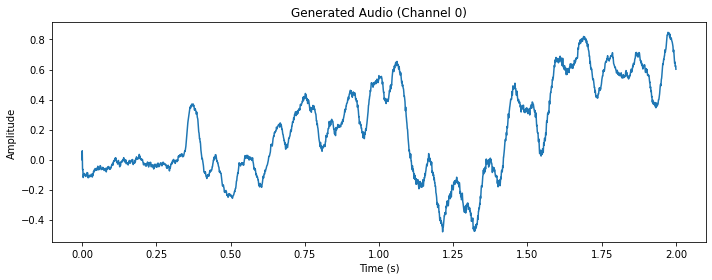

In [12]:
# function accepts: [num_samples, Channel. length]
genetated_audio = genetated_audio.squeeze(-1)
plot_generated_audio(genetated_audio, sample_rate=3000)

AttributeError: 'TVAEParams' object has no attribute 'plot_dir'

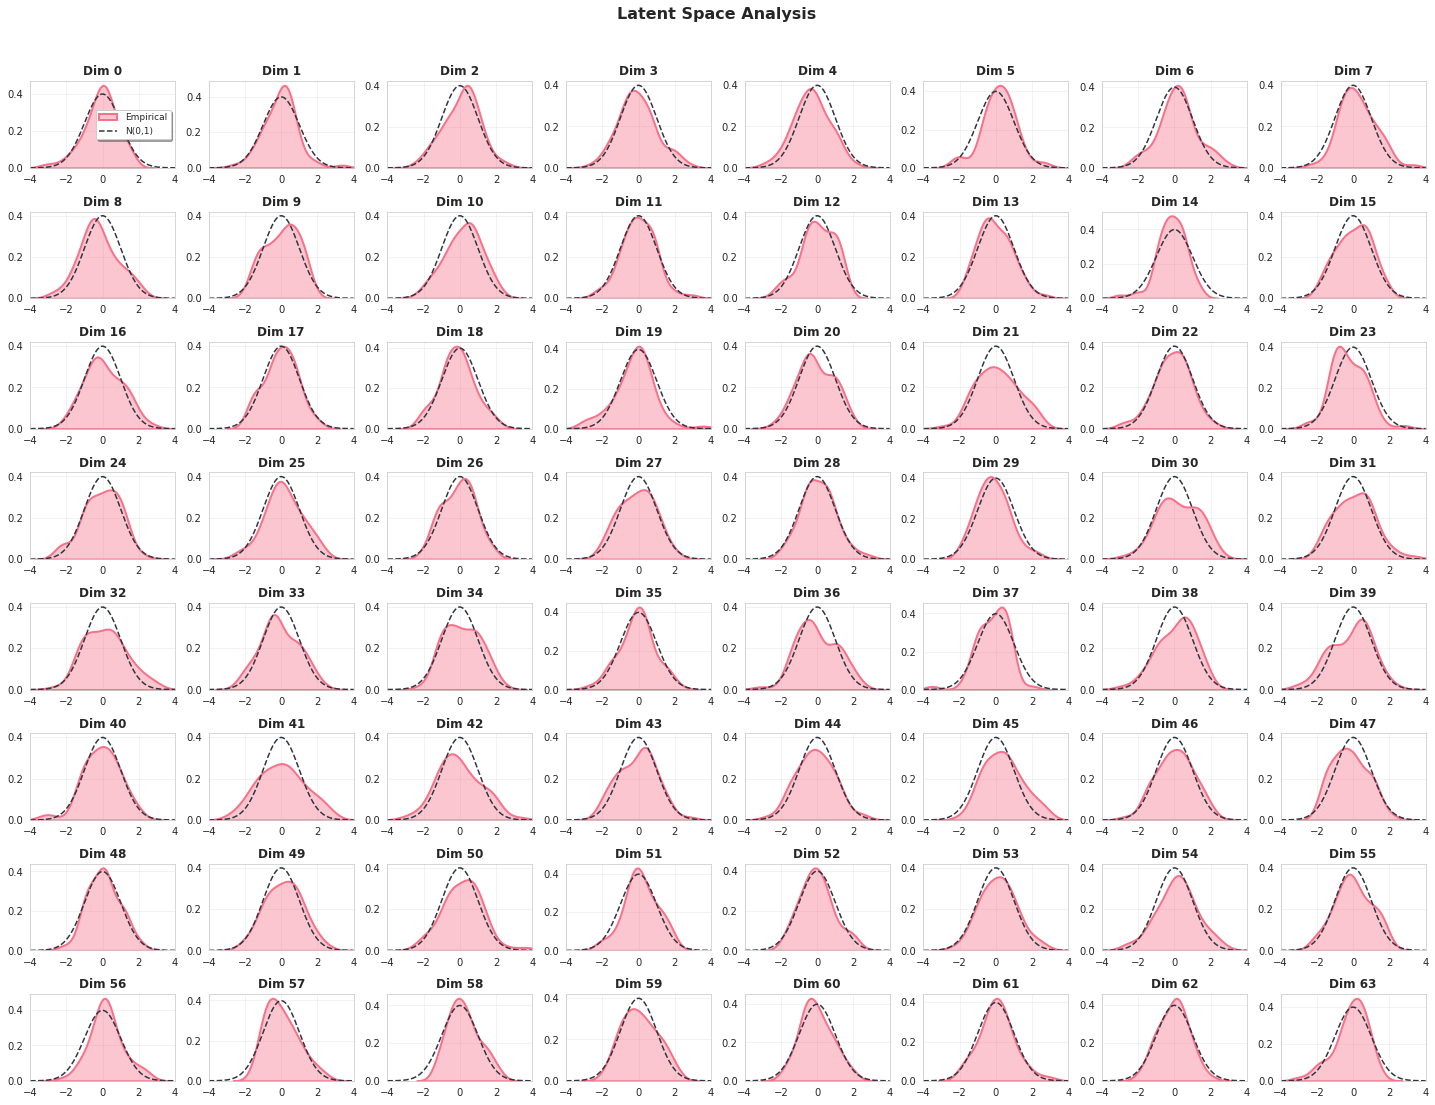

In [16]:
latent = get_tvae_latent(rawhp=hp, model=model, dataloader=val_loader).cpu().numpy()
visualize_latent_distribution(z=latent, hp=hp, save_path="tvae_z_dist.png")

In [14]:
latent.shape

(64, 64)